In [ ]:
from CellClass.CNN import create_single_patches as patches

In [ ]:
in_dir = "/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/MYCN_SpikeIn/results/patches"
out_dir = "/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/MYCN_SpikeIn/results/single_patches"
patches.create_single_patches(in_dir, out_dir, sample="S29", n=200)

In [ ]:
import os
from tqdm import tqdm
base = "/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/MYCN_SpikeIn/results/single_patches"
pos = [x for x in os.listdir(base) if "S19" in x]
neg = [x for x in os.listdir(base) if "S29" in x]
len(pos), len(neg)

In [ ]:
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

plt.rcParams["figure.figsize"] = 10, 10

DAPI = cv2.imread("/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/MYCN_SpikeIn/test_images/DAPI_1.TIF", 0)
RED = cv2.imread("/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/MYCN_SpikeIn/test_images/RED_1.TIF", 0)

dat = pd.read_csv("/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/MYCN_SpikeIn/test_images/RED_1_SPOTS.CSV")
dat.head()

DAPI.shape
X = dat.iloc[3:, 4].astype(float).tolist()
Y = dat.iloc[3:, 5].astype(float).tolist()
X = np.array(X, dtype=int)
Y = np.array(Y, dtype=int)

masks = cv2.imread("/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/MYCN_SpikeIn/test_images/_OBSERVER0/DAPI_1-SIMON_procecced.png", cv2.IMREAD_ANYDEPTH)
spots = np.zeros_like(masks)
spots[Y,X] = 1

test = np.zeros_like(masks)
test[masks != 0] = 1
k = np.ones((7,7)).astype(np.uint8)
masks = cv2.dilate(masks.astype(np.uint16), k)
plt.imshow(masks)
plt.show()

plt.imshow(np.stack((RED, np.zeros_like(RED), DAPI), axis=-1))
#plt.imshow(DAPI)
plt.imshow(test, alpha=0.1)
plt.scatter(X,Y, marker="o", facecolors="None", edgecolors="red")
plt.show()

lens = []
for n, c in enumerate(tqdm(np.unique(masks))):
    if c == 0:
        continue
    tmp = np.copy(masks)
    tmp[masks != c] = 0
    tmp[masks == c] = 1

    tmp_spots = np.copy(spots)
    tmp_spots[tmp != 1] = 0
    idxs = np.where(tmp_spots)
    lens.append(len(idxs[0]))

unique, counts = np.unique(lens, return_counts=True)

print(dict(zip(unique, counts)))

In [1]:
import sys
import subprocess
import numpy as np
import PySimpleGUI as sg    
from PIL import Image, ImageTk
import cv2  
import random
import pickle as pkl
from sklearn.metrics import confusion_matrix

sample = "S6_"
num = 100

def update(w, img):
    img = cv2.resize(img, (512, 512))
    PIL_image = Image.fromarray(np.uint8(img*255)).convert('RGB')
    image = ImageTk.PhotoImage(PIL_image)
    w['-IMAGE-'].update(data=image)

def patchpath2img(p: str) -> np.ndarray:
   
    try:
        with open(p, "rb") as fin:
            dat = pkl.load(fin)
        tmp = np.copy(dat.RGB)
        tmp[~dat.mask] = 0

        return tmp
    except:
        print("Something went wrong")
 
#sg.theme('Default')
font = ("Arial", 12)
sg.theme('Light Grey 6')

my_img = sg.Image(key='-IMAGE-')

layout = [
    [sg.Column([[sg.Text('Enter your Name:' ), sg.Input(key='-IN-', do_not_clear=True)]], justification='center')],
    [sg.Column([[my_img]], justification='center')],
    [sg.Column([[sg.Button('AMPLIFIED', bind_return_key=True, key="-AMP-"), sg.Button('NON-AMPLIFIED', bind_return_key=True, key="-NAMP-")]], justification="center")],#, sg.Button('UNCERTAIN', bind_return_key=True, key="-UNCERT-")]], justification='center')],
    [sg.Column([[sg.Button('BACK', bind_return_key=True, key="-BACK-"), sg.Text(f"0 / {num}", key="-NUM-")]], justification="center")]
    ]      

window = sg.Window('AMP VS. NON-AMP', layout, finalize=True, font=font)     

base = "/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/MYCN_SpikeIn/results/single_patches"
imgs = [os.path.join(base, x) for x in os.listdir(base) if sample in x]
random.shuffle(imgs)
imgs = imgs[:num]

with open(f"/home/simon_g/tmp/samples_{sample}.txt", "w+") as fout:
    [fout.write(x + "\n") for x in imgs]

ev_c = 0
res_list = []
update(window, patchpath2img(imgs[ev_c]))
while True: # The Event Loop
    
    event, values = window.read() 
    print(ev_c)

    
    if event in ["-AMP-", "-NAMP-", "-UNCERT-"]:

        if event == "-AMP-":
            res_list.append(1)#, int("S19" in imgs[ev_c])))
        if event == "-NAMP-":
            res_list.append(0)#, int("S19" in imgs[ev_c])))
        # if event == "-UNCERT-":
        #     res_list.append(-1)#, int("S19" in imgs[ev_c])))

        ev_c += 1
        
        if ev_c == num:
            with open(f"/home/simon_g/tmp/{values['-IN-']}_{sample}results.pkl", "wb+") as fout:
                pkl.dump(np.array(res_list), fout)
            break
        
        window['-NUM-'].update(f"{ev_c} / {num}")
        update(window, patchpath2img(imgs[ev_c]))

    if event == "-BACK-":
        res_list.pop()
        ev_c -=1
        update(window, patchpath2img(imgs[ev_c]))

    if event == sg.WIN_CLOSED or event == 'Exit':
        break  

window.close()

0
1
2
3
4
5


In [1]:
import torch
import pickle as pkl
from CellClass.CNN import ClassificationCNN
state = torch.load("/home/simon_g/src/MICCAI/trained_models/20220627_175745/CNN_Model_20220629_092150700.pt", map_location="cpu")
model = ClassificationCNN()
model.load_state_dict(state["model_state_dict"])

<All keys matched successfully>

In [4]:
sample = "S6_"
with open(f"/home/simon_g/tmp/samples_{sample}.txt", "r") as fout:
    files = [x.strip() for x in fout.readlines()]

In [5]:
import numpy as np

ptchs = []
for file in files[:100]: 
    with open(file, "rb") as fin:
        p = pkl.load(fin)
        tmp = p.RGB
        tmp[~p.mask] = 0
        ptchs.append(tmp)
        
ptchs = torch.tensor(np.array(ptchs))
ptchs.shape

torch.Size([100, 128, 128, 3])

In [6]:
ptchs = ptchs.permute(0,3,1,2)
ptchs.shape

torch.Size([100, 3, 128, 128])

In [14]:
model = model.to("cuda")
ptchs = ptchs.to("cuda")
model.eval()

ret = torch.sigmoid(model(ptchs))   

tensor([[3.1227e-04],
        [8.2658e-05],
        [1.3562e-04],
        [9.0731e-04],
        [7.6834e-05],
        [2.5878e-02],
        [1.2770e-04],
        [1.0171e-04],
        [2.1433e-04],
        [9.9531e-05],
        [2.6109e-04],
        [3.4021e-05],
        [1.8760e-04],
        [5.9742e-05],
        [7.4472e-05],
        [1.5795e-04],
        [2.0527e-03],
        [6.6676e-05],
        [1.9772e-04],
        [1.4452e-04],
        [4.5048e-05],
        [9.1800e-05],
        [1.1187e-03],
        [3.6368e-07],
        [1.9968e-04],
        [1.1509e-03],
        [1.8938e-04],
        [4.3704e-05],
        [3.5051e-05],
        [1.1148e-04],
        [8.3489e-05],
        [2.8590e-04],
        [9.9627e-05],
        [2.8850e-04],
        [1.6172e-04],
        [1.8186e-04],
        [2.0723e-04],
        [2.3458e-04],
        [1.3386e-04],
        [1.3798e-04],
        [4.0067e-04],
        [1.2814e-04],
        [2.0373e-05],
        [9.5460e-06],
        [8.7738e-05],
        [1

In [15]:
ret = torch.round(ret).cpu().detach().numpy().squeeze()
ret

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [19]:
with open(f"/home/simon_g/tmp/Simon_{sample}results.pkl", "rb") as fin:
    results = pkl.load(fin)

In [20]:
results.shape, ret.astype(int).shape

((100,), (100,))

In [22]:
comparison = np.stack((ret,results),axis=-1)

In [23]:
from sklearn.metrics import confusion_matrix
confusion_matrix(comparison[:,0], comparison[:,1])

array([[92,  8],
       [ 0,  0]])

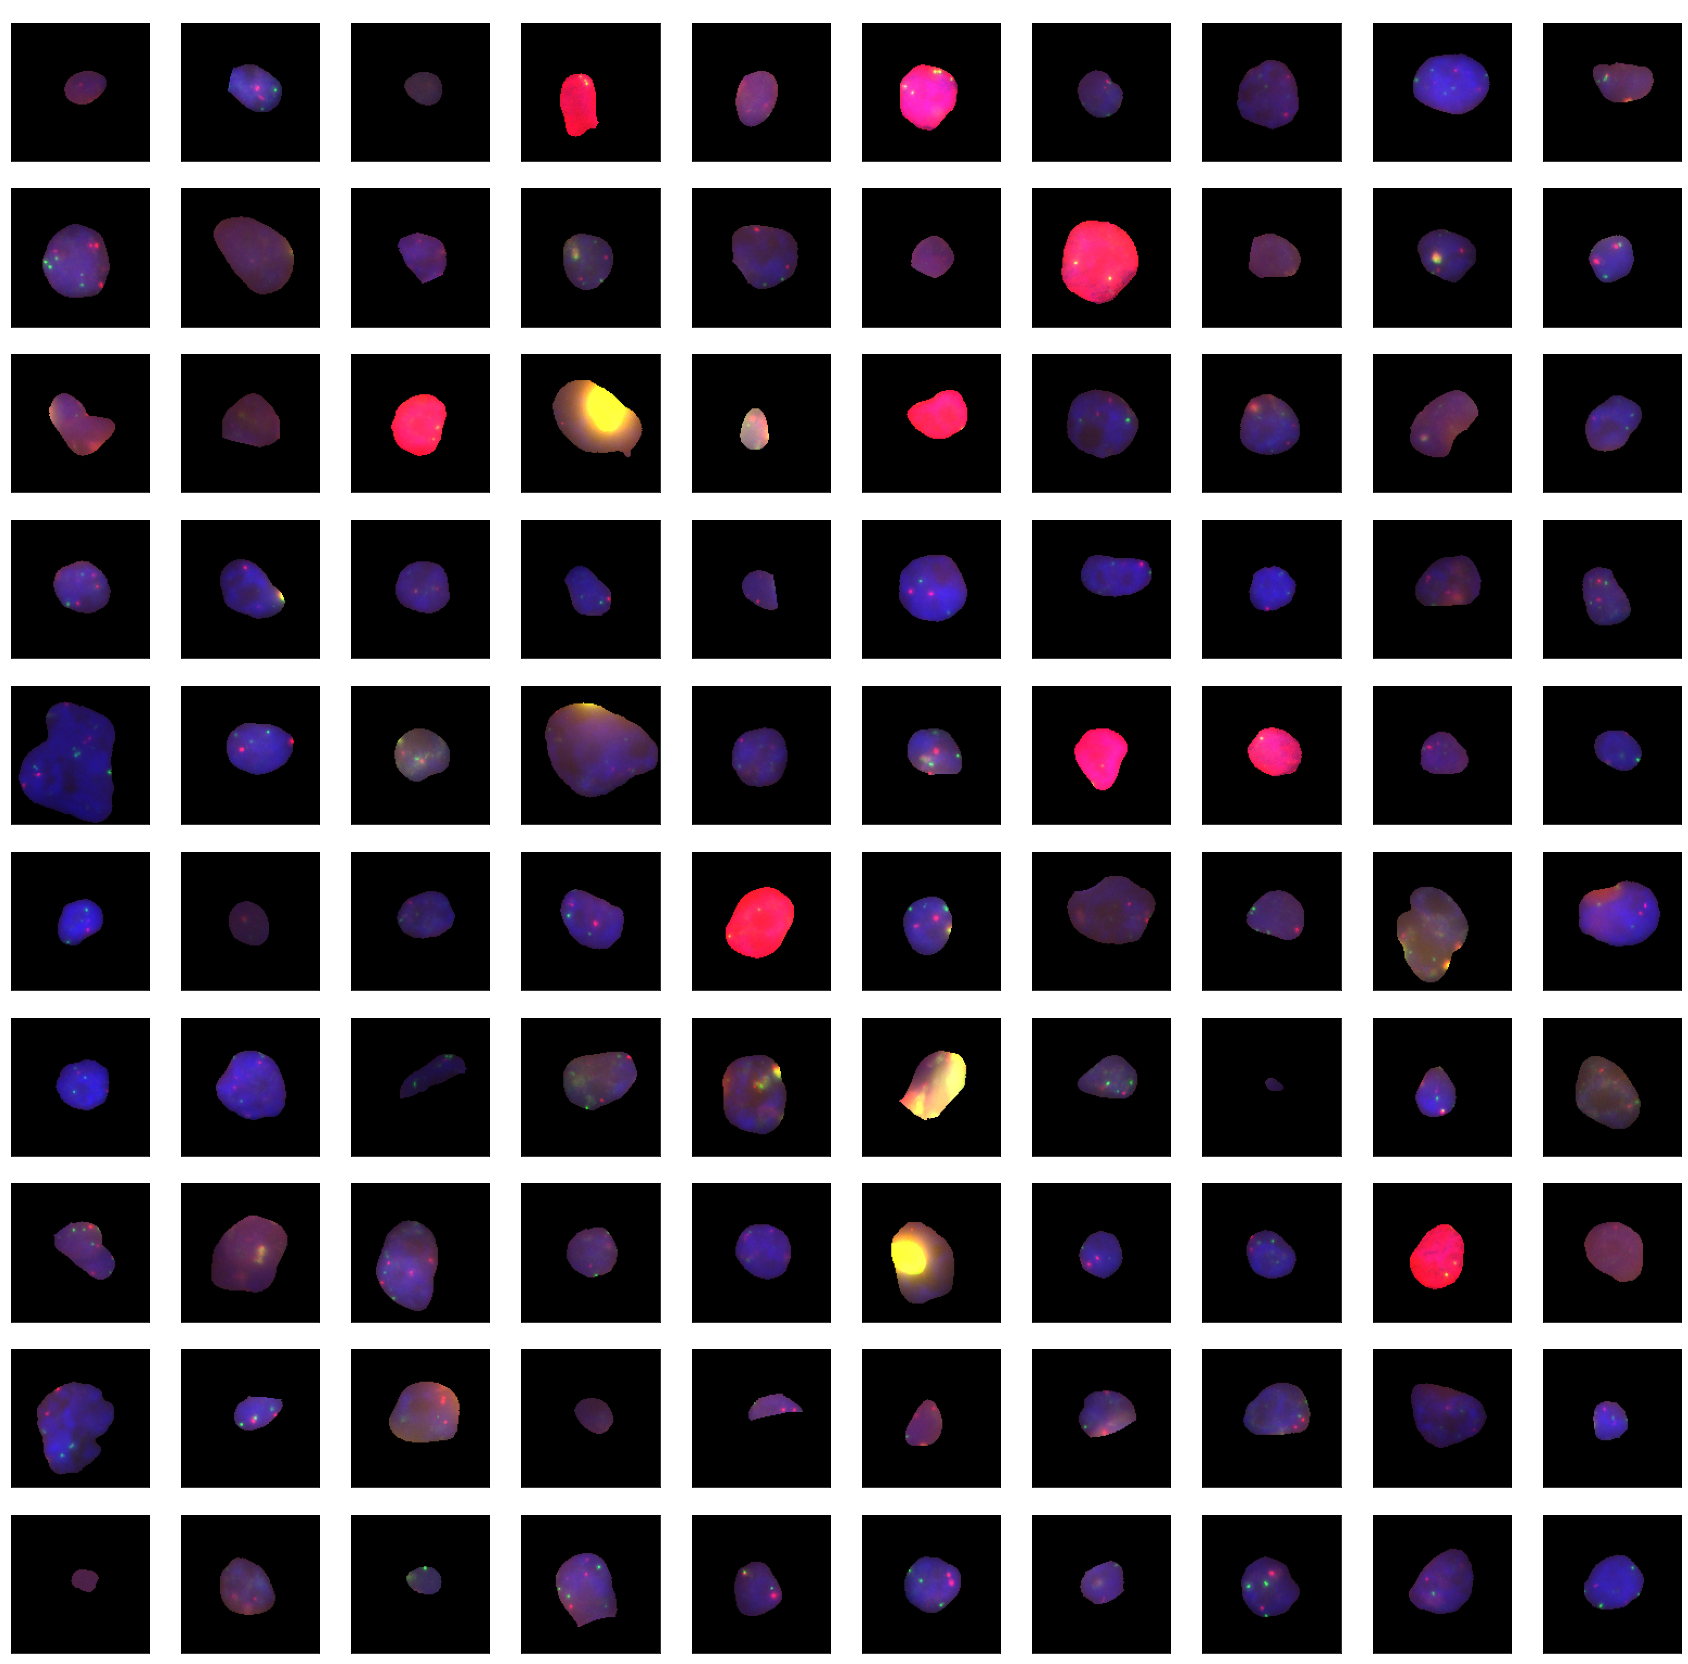

In [25]:
from CellClass.utils import gridPlot
gridPlot(ptchs.permute(0,2,3,1).detach().cpu().numpy(), ret, results)

In [68]:
import numpy as np
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import pickle as pkl
import os
import random
import shutil
import os

out = "/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/MYCN_SpikeIn/results/single_patches"

normalized_images = []
images = []
masks = []
files = [x for x in os.listdir(out) if "S19_" in x or "S29_" in x]
random.shuffle(files)

for n, file in enumerate(tqdm(files[:1000])):
    with open(os.path.join(out, file), "rb") as fin:
        patch = pkl.load(fin)
        tmp = patch.RGB
        tmp[~patch.mask] = 0
        masks.append(patch.mask)
        images.append(tmp)
        tmp = np.copy(tmp)
        for i in range(tmp.shape[2]):
            tmp[..., i] = (tmp[..., i]-tmp[..., i].min())/(tmp[..., i].max()-tmp[..., i].min())
        normalized_images.append(tmp)
        
images_arr = np.array(images)
normalized_images_arr = np.array(normalized_images)
masks = np.array(masks)
szs = [np.sum(mask) for mask in masks]
masks_mean = np.mean(szs)
masks_std = np.std(szs)

R_means = np.mean(images_arr[masks, 0])
G_means = np.mean(images_arr[masks, 1])
B_means = np.mean(images_arr[masks, 2])
R_stds = np.std(images_arr[masks, 0])
G_stds = np.std(images_arr[masks, 1])
B_stds = np.std(images_arr[masks, 2])

nR_means = np.mean(normalized_images_arr[masks, 0])
nG_means = np.mean(normalized_images_arr[masks, 1])
nB_means = np.mean(normalized_images_arr[masks, 2])
nR_stds = np.std(normalized_images_arr[masks, 0])
nG_stds = np.std(normalized_images_arr[masks, 1])
nB_stds = np.std(normalized_images_arr[masks, 2])
 
print(R_means, G_means, B_means, R_stds, G_stds, B_stds)
print(nR_means, nG_means, nB_means, nR_stds, nG_stds, nB_stds)
print(masks_mean, masks_std)

100%|██████████| 1000/1000 [01:04<00:00, 15.50it/s]


0.146186 0.26284465 0.49581406 0.08738267 0.20710759 0.1588277
0.25214872 0.36972764 0.6954613 0.13385996 0.20726952 0.15303221
2200.641 731.7052426482949


In [229]:
import torch

means_orig = torch.tensor([0.24709156, 0.3544275, 0.69437116])
stds_orig = torch.tensor([0.13086402, 0.20033397, 0.15267912])
szs_mean = 2200.641 
szs_std = 731.7052426482949

patches_dir = "/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/MYCN_SpikeIn/results/single_patches"
dilutions = np.unique([x.split("_")[0] + "_" for x in os.listdir(patches_dir)])


for dil in dilutions:
    print(dil)
    files = [os.path.join(patches_dir, x) for x in os.listdir(patches_dir) if dil in x][:1000]
    random.shuffle(files)

    ims = []
    masks = []
    for file in files:
        
        with open(file, "rb") as fin:
            patch = pkl.load(fin)
        masked = patch.RGB
        masked[~patch.mask]=0
        masks.append(patch.mask)

        ret = np.copy(masked)       
        for i in range(ret.shape[-1]):
            ret[..., i] = (ret[..., i]-ret[..., i].min())/(ret[..., i].max()-ret[..., i].min())
                
        ims.append(ret)
        
    ims = np.array(ims)
    
    means = []
    stds = []
    szs = []
    for im, mask in zip(ims,masks):
        means.append([im[mask,0].mean(), im[mask,1].mean(), im[mask,2].mean()])
        stds.append([im[mask,0].std(), im[mask,1].std(), im[mask,2].std()])
        szs.append(np.sum(mask))
        
    means = np.array(means)
    stds = np.array(stds)
    szs = np.array(szs)
        
    discarded = []
    kept = []
    used_files = []
    discarded_files = []
    for mean, sz, im, file  in zip(means, szs, ims, files):
        discard = False
        if mean[0] > (means_orig[0] + 2*stds_orig[0]) or mean[0] < (means_orig[0] - 2*stds_orig[0]):
            discard = True
            continue
        if mean[1] > (means_orig[1] + 3*stds_orig[1]) or mean[1] < (means_orig[1] - 3*stds_orig[1]):
            discard = True
            continue
        if mean[2] > (means_orig[2] + 2*stds_orig[2]) or mean[2] < (means_orig[2] - 2*stds_orig[2]):
            discard = True
            continue
        if sz < szs_mean - 2*szs_std or sz > szs_mean + 3*szs_std:
            discard = True
            continue
                
        if discard:
            discarded.append(im)
            discarded_files.append(file)
            
        else:
            kept.append(im)
            used_files.append(file)
            
    discarded = np.array(discarded)
    kept = np.array(kept)

    print(len(discarded), len(kept))
    kept_path = "/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/MYCN_SpikeIn/results/kept"
    discarded_path =  "/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/MYCN_SpikeIn/results/discarded"
    for file in tqdm(used_files):
        filename = file.split("/")[-1]
        shutil.copyfile(file, os.path.join(kept_path, filename))
        
    for file in tqdm(discarded_files):
        filename = file.split("/")[-1]
        shutil.copyfile(file, os.path.join(discarded_path, filename))

S11_
20 980


100%|██████████| 20/20 [00:00<00:00, 54.57it/s]


S12_
115 885


100%|██████████| 115/115 [00:02<00:00, 52.44it/s]


S19_
52 948


100%|██████████| 52/52 [00:00<00:00, 52.11it/s]


S1b_
73 927


100%|██████████| 73/73 [00:01<00:00, 50.60it/s]


S20_
20 980


100%|██████████| 20/20 [00:00<00:00, 51.52it/s]


S29_
50 950


100%|██████████| 50/50 [00:00<00:00, 54.92it/s]


S2_
36 964


100%|██████████| 36/36 [00:00<00:00, 51.93it/s]


S30_
27 973


100%|██████████| 27/27 [00:00<00:00, 37.33it/s]


S31_
26 974


100%|██████████| 26/26 [00:00<00:00, 27.45it/s]


S32_
32 968


100%|██████████| 32/32 [00:00<00:00, 34.30it/s]


S33_
140 860


100%|██████████| 140/140 [00:04<00:00, 31.24it/s]


S34_
43 957


100%|██████████| 43/43 [00:00<00:00, 44.85it/s]


S3_
139 861


100%|██████████| 139/139 [00:02<00:00, 54.72it/s]


S4_
21 979


100%|██████████| 21/21 [00:00<00:00, 53.67it/s]


S6_
248 752


100%|██████████| 248/248 [00:04<00:00, 53.24it/s]


S7_
30 970


100%|██████████| 30/30 [00:00<00:00, 52.92it/s]


S8_
45 955


100%|██████████| 45/45 [00:00<00:00, 47.81it/s]


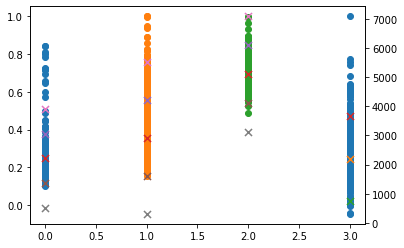

In [213]:
import matplotlib.pyplot as plt

fig, ax0 = plt.subplots()


ax0.scatter(np.ones(len(means))*0, means[:, 0])
ax0.scatter(np.ones(len(means))*1, means[:, 1])
ax0.scatter(np.ones(len(means))*2, means[:, 2])

ax1 = ax0.twinx()
ax1.scatter(np.ones(len(means))*3, szs)

ax0.scatter([0,1,2], means_orig, marker="x", s=50)
ax0.scatter([0,1,2], means_orig + stds_orig, marker="x", s=50)
ax0.scatter([0,1,2], means_orig - stds_orig, marker="x", s=50)
ax0.scatter([0,1,2], means_orig + 2*stds_orig, marker="x", s=50)
ax0.scatter([0,1,2], means_orig - 2*stds_orig, marker="x", s=50)
ax1.scatter([3], szs_mean, marker="x", s=50)
ax1.scatter([3], szs_mean - 2*szs_std, marker="x", s=50)
ax1.scatter([3], szs_mean + 2*szs_std, marker="x", s=50)

In [ ]:
from CellClass.utils import gridPlot


kept_path = "/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/MYCN_SpikeIn/results/kept"
discarded_path =  "/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/MYCN_SpikeIn/results/discarded"

discarded = os.listdir(discarded_path)
random.shuffle(discarded)

ims = []

for file in discarded:
    
    with open(file, "rb") as fin:
        patch = pkl.load(fin)
    masked = patch.RGB
    masked[~patch.mask]=0
    masks.append(patch.mask)

    ret = np.copy(masked)       
    for i in range(ret.shape[-1]):
        ret[..., i] = (ret[..., i]-ret[..., i].min())/(ret[..., i].max()-ret[..., i].min())
    ims.append(ret)

ims = np.array(ims)

gridPlot(ims, labels=discarded)

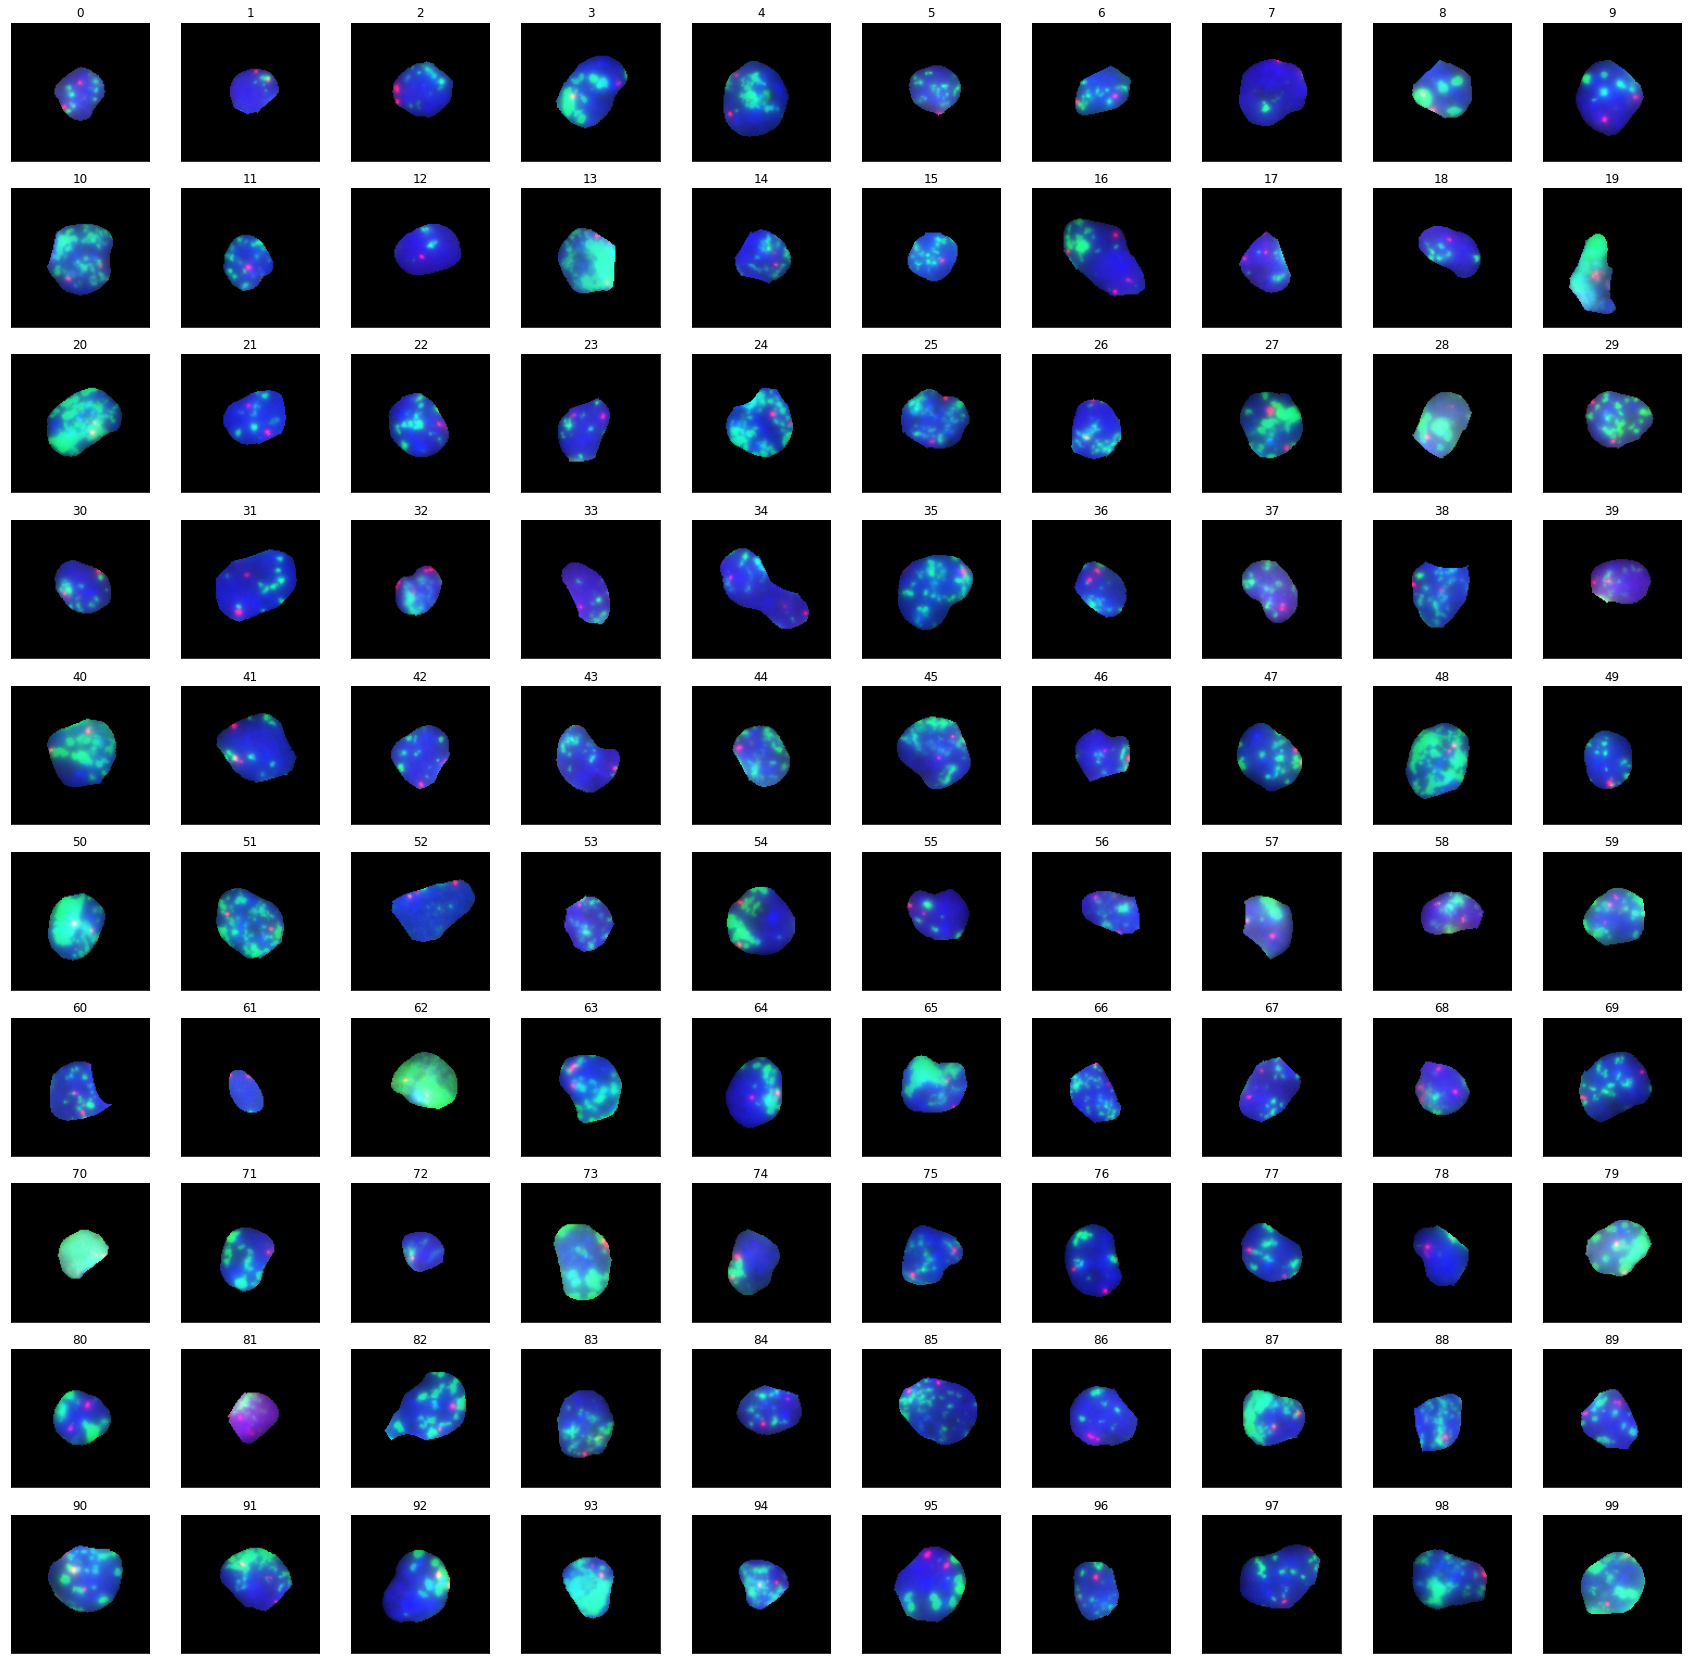

In [224]:
gridPlot(kept)

In [185]:
len(used_files)

435

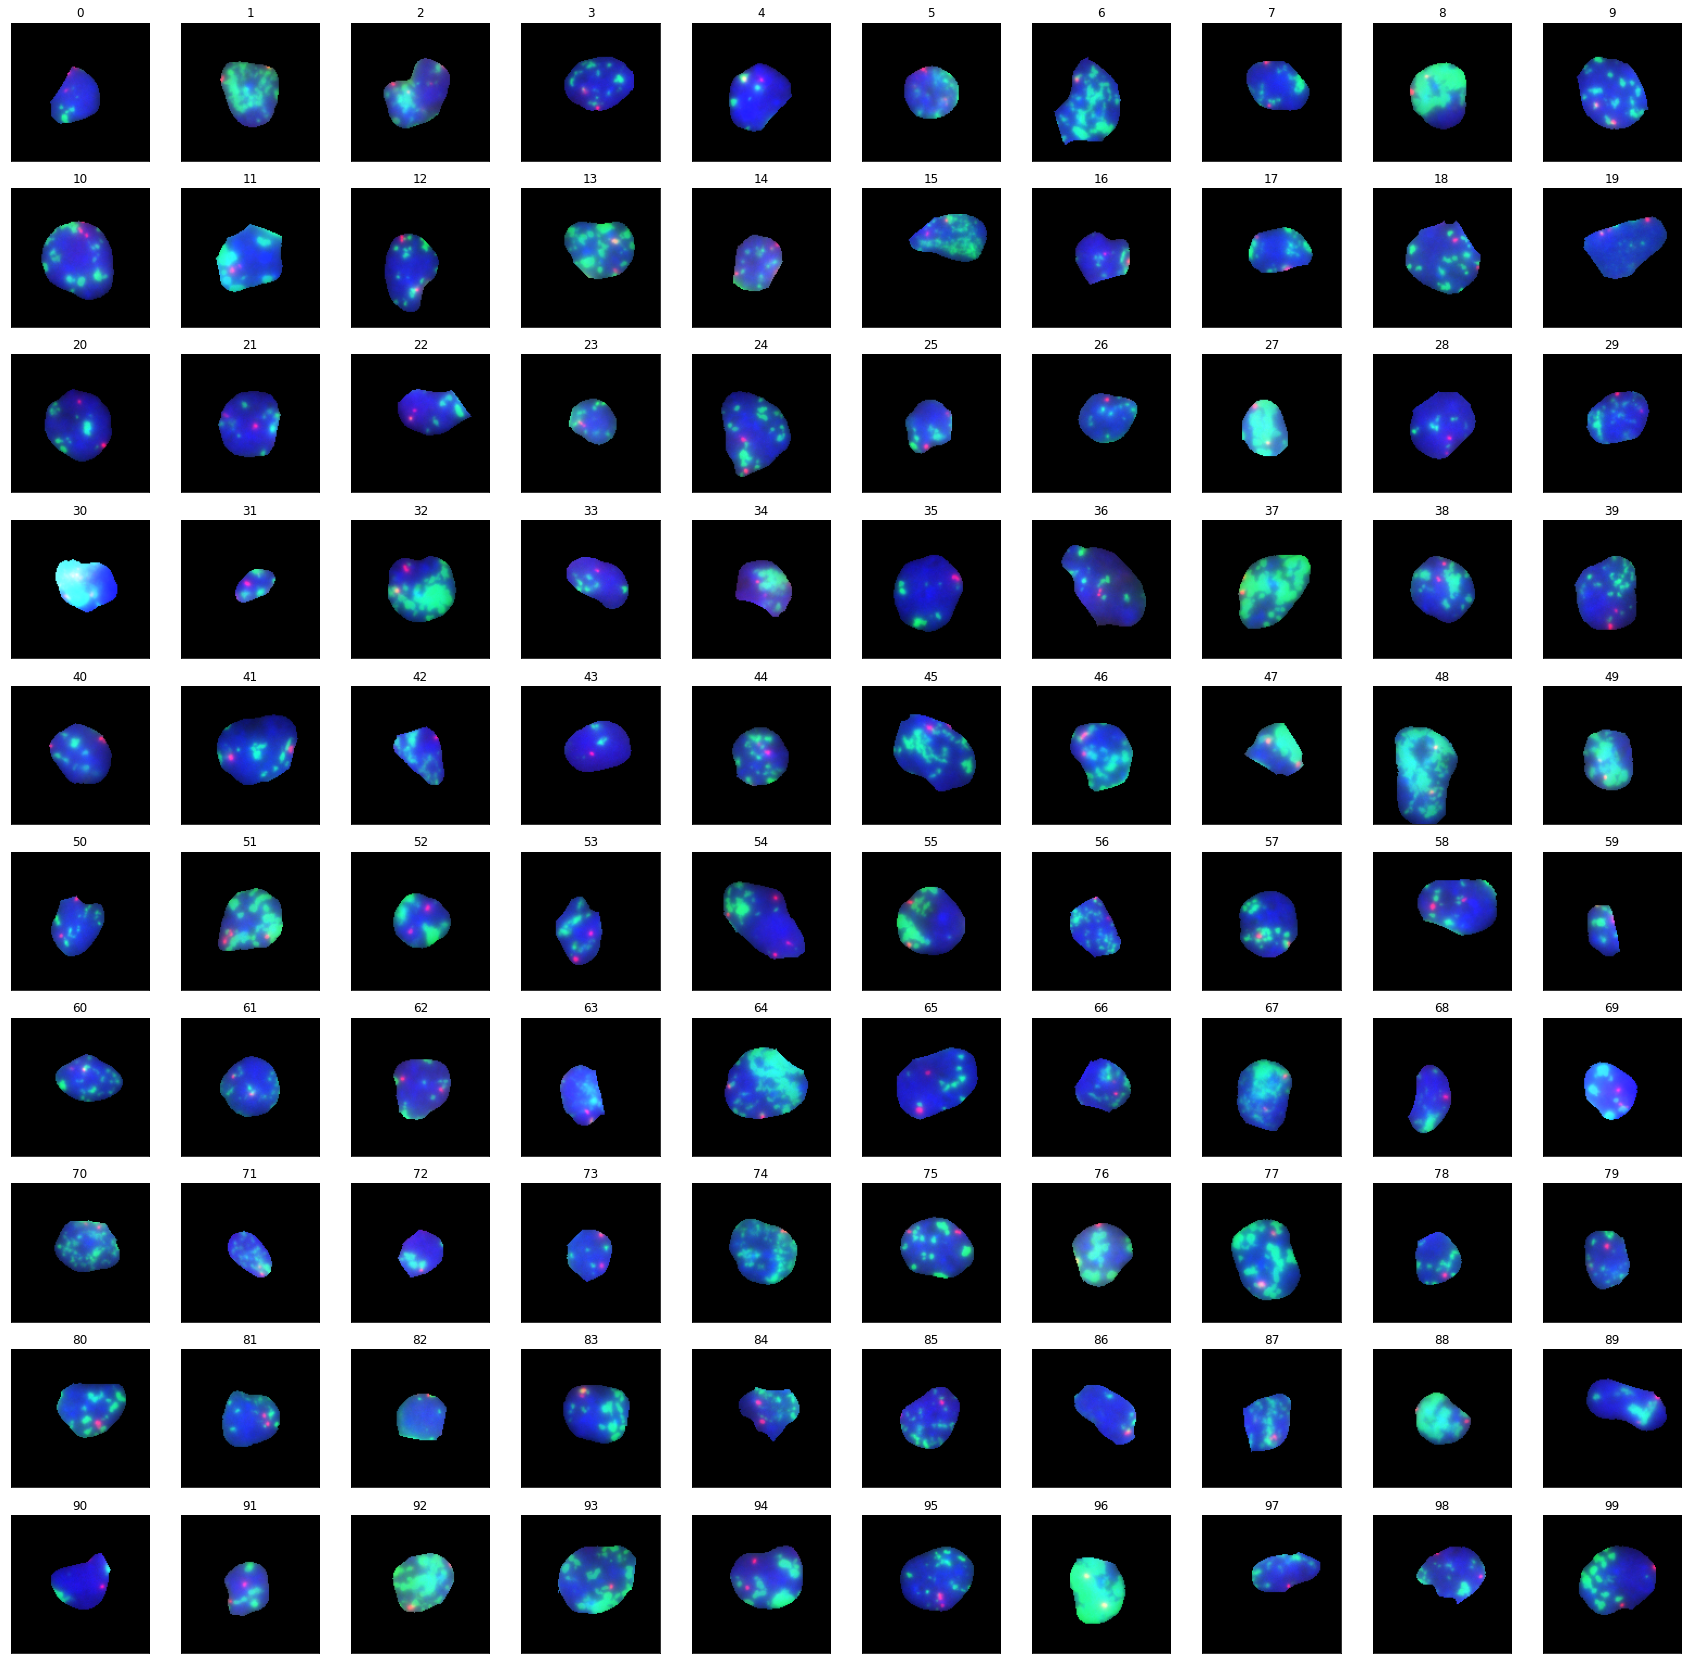

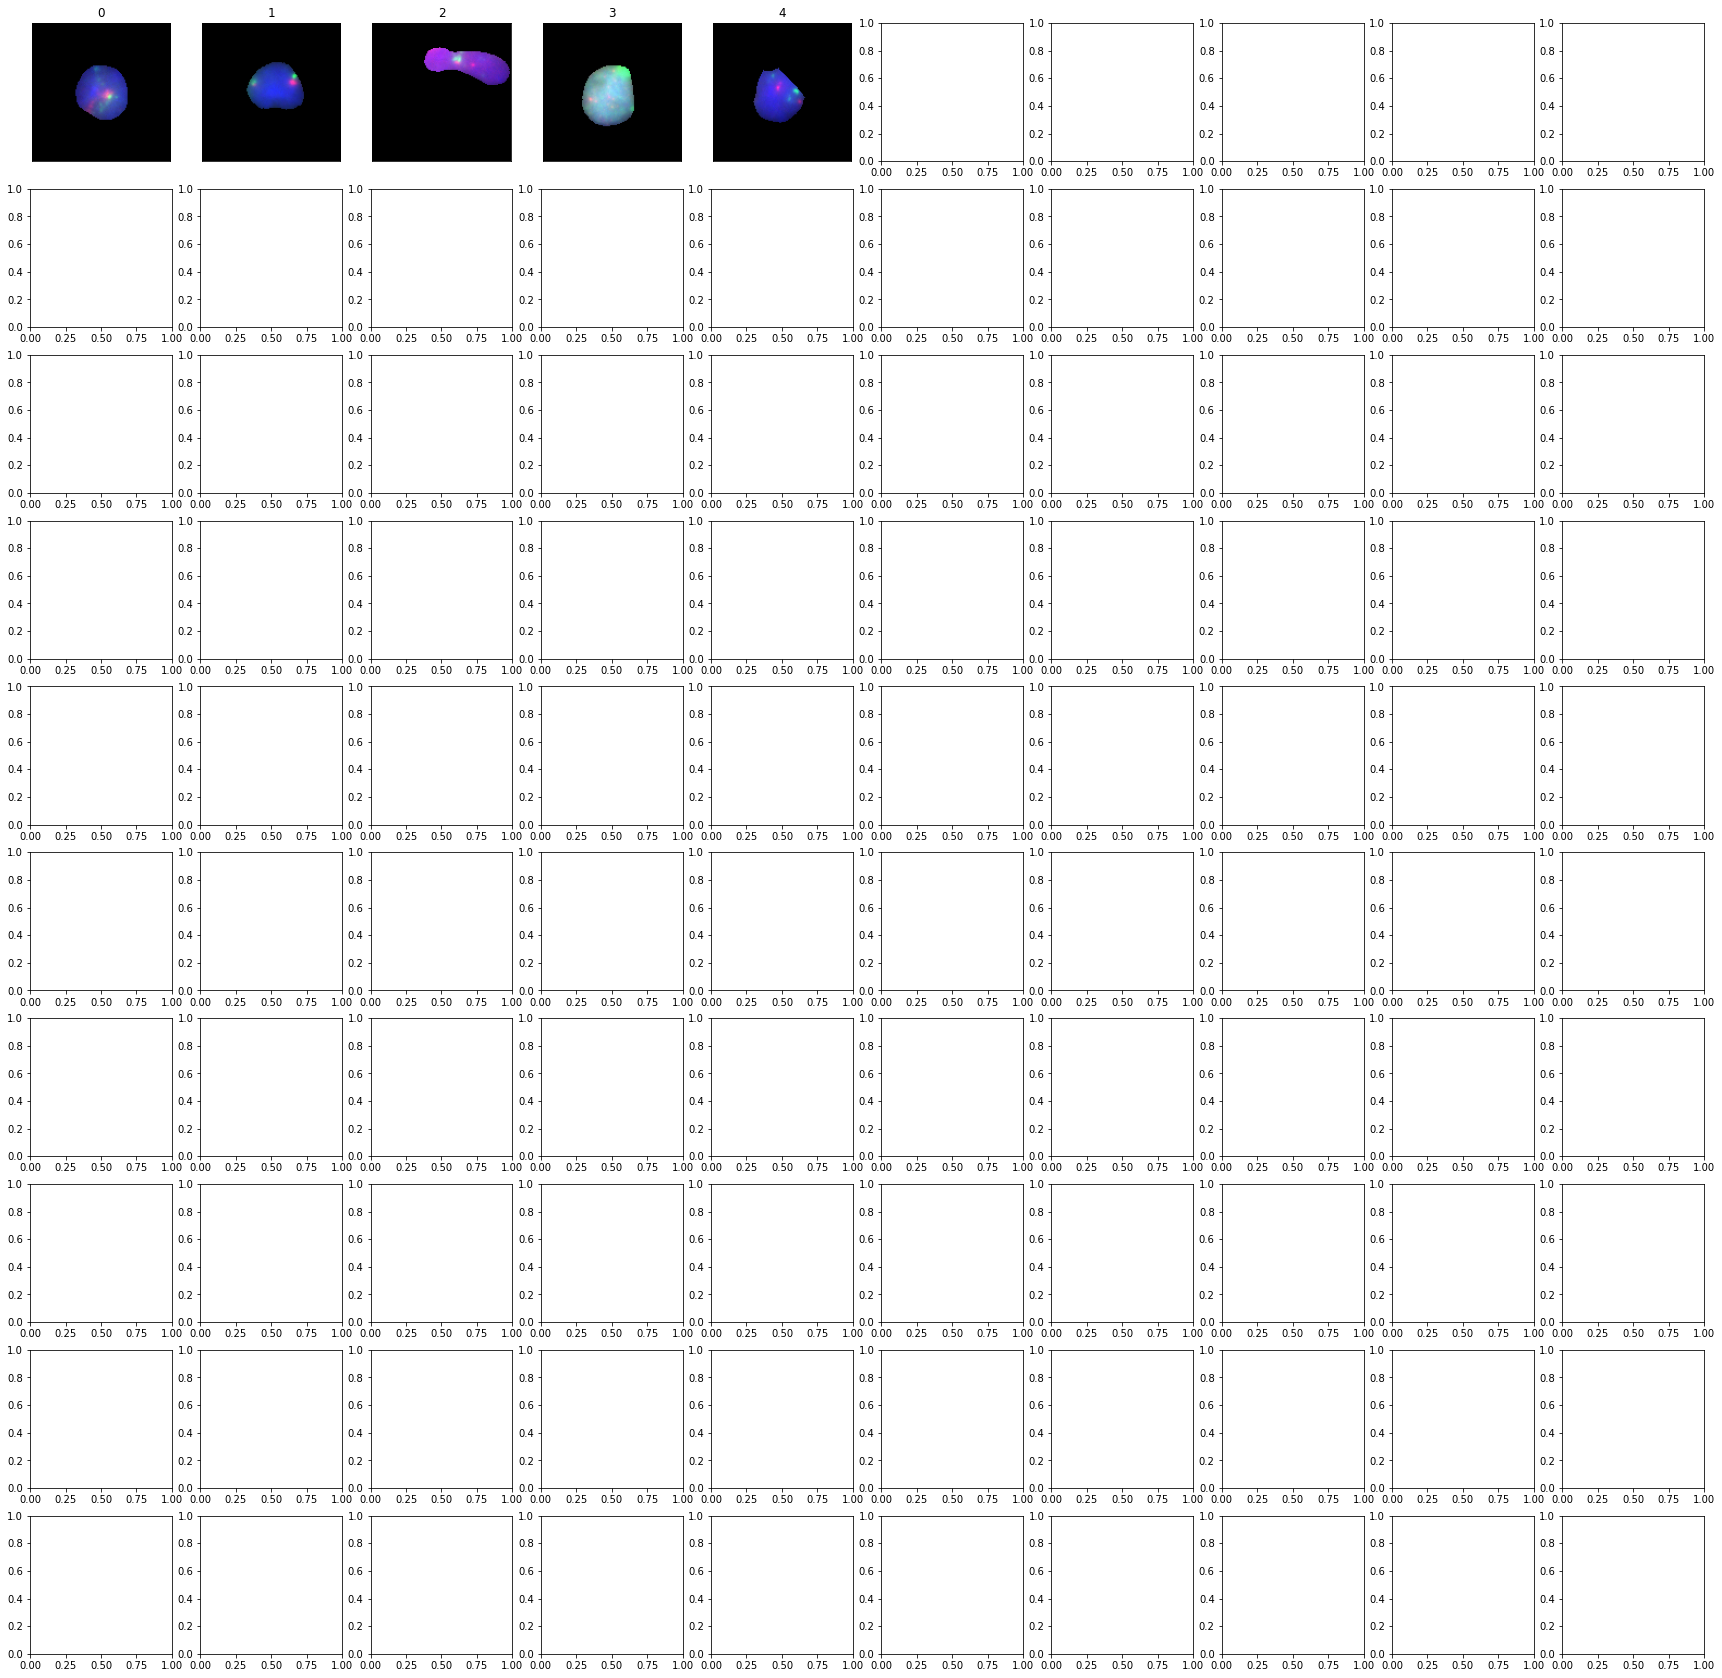

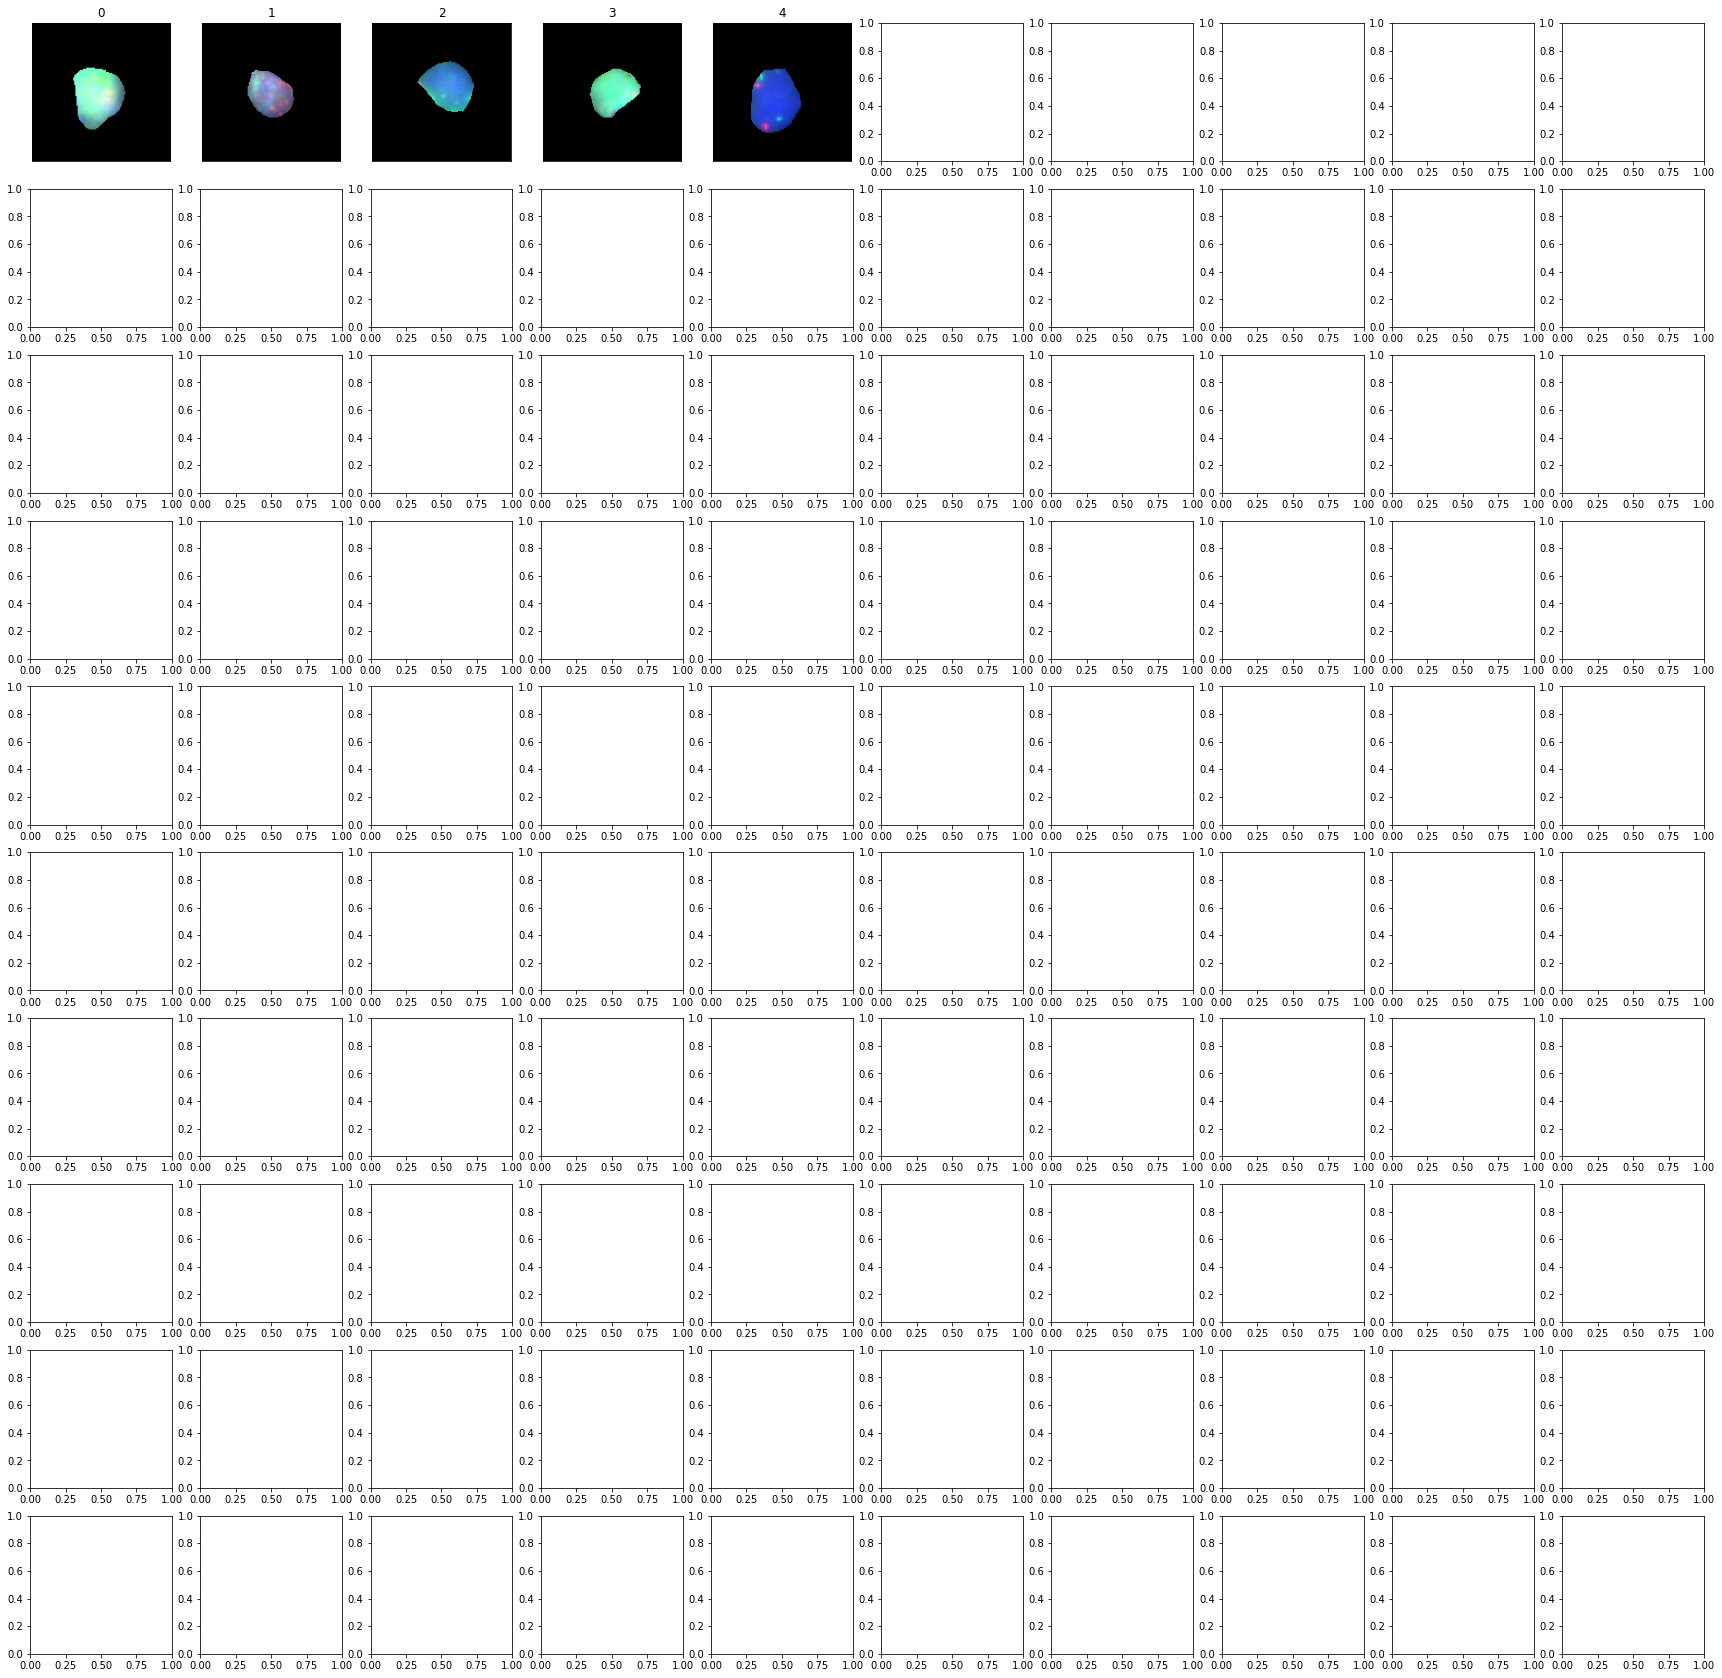

In [4]:
from CellClass import utils
from CellClass.CNN import transformations
from CellClass import CNN
from CellClass.CNN import dataset
from torch.utils.data import DataLoader
from CellClass.CNN.transformations import DeNormalize
import torch
from CellClass.utils import gridPlot
import CellClass.CNN.training as T
import numpy as np
import os
import random
import matplotlib.pyplot as plt

save_dir = "/home/simon_g/src/MICCAI/trained_models"

setups = os.listdir(save_dir)

setup_best = []
for setup in setups:
    models = [os.path.join(save_dir, setup, x) for x in os.listdir(os.path.join(save_dir, setup)) if ".pt" in x]
    
    best = np.inf
    for model in models:
        dict_mod = torch.load(model)
        if dict_mod["validation_loss"] < best:
            best = dict_mod["validation_loss"]
            best_model = model
        
    setup_best.append([setup, best_model])
    
setup_best = np.array(setup_best)
patches_dir = "/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/MYCN_SpikeIn/results/kept"
dilutions = np.unique([x.split("_")[0] + "_" for x in os.listdir(patches_dir)])

best = torch.load(setup_best[0][1], map_location="cpu")
model = CNN.ClassificationCNN()
model.load_state_dict(best["model_state_dict"])

# for dil in dilutions:
    
files = [os.path.join(patches_dir, x) for x in os.listdir(patches_dir) if "S19_" in x]
random.shuffle(files)
filenames = [x.split("/")[-1] for x in files]
dilution = dataset.PatchDataset(files[:1000], eval=True, rescale_intensity=True)
dilution_loader = DataLoader(dilution, 128, num_workers=2)
ims, labels, percentage, preds = T.predict_dilution(model, dilution_loader, return_output=True)
ims = np.array(ims)
ims = torch.tensor(ims).permute(0,3,1,2)
t = DeNormalize(rescaled=True)
ims = t(ims).squeeze().permute(0,2,3,1).detach().numpy()
labels = np.array(labels).squeeze().astype(int)
pos = ims[labels == 1]
neg = ims[labels == 0]

preds = torch.sigmoid(torch.tensor(preds).squeeze())

pos = []
neg = []
unc = []
for pred, im in zip(preds, ims):
    if pred > 0.8:
        pos.append(im)
    elif pred < 0.2:
        neg.append(im)
    else:
        unc.append(im)
        
gridPlot(pos)
gridPlot(neg)  
gridPlot(unc)